# Tarea 2
## Laboratorio de Datos

# 1 Carga y transformación de Datos

In [ ]:
#Estas lineas corren solo en google colab:
import os.path 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  if os.path.exists('/content/ChestXRay2017.zip'):
    print("Datos ya descargados")
  else:
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
    !unzip /content/ChestXRay2017.zip

In [25]:
# librerías usadas
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage import io
from skimage.color import gray2rgb


# 1
# iniciar datos

"""
Funciones loaders 
- pil_loader        :   carga con pil
- skimage_loader    :   carga con skimage
- opencv_loader     :   carga con opencv
"""
def opencv_loader(path):
    bgr_image = cv2.imread(path)
    return bgr_image
def pil_loader(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb
def skimage_loader(path):
    image=io.imread(path)
    return gray2rgb(image)

div= np.iinfo('uint8').max # maximo valor de tipo uint8
transformers=transforms.Compose(
                [transforms.Resize([224,224]),
                #transforms.Normalize(mean=0,std = div, inplace = True),
                 transforms.RandomRotation(degrees=20),
                 transforms.RandomHorizontalFlip(),
                 transforms.ColorJitter(brightness=[1.2, 1.5]),
                 transforms.ToTensor() # ToTensor convierte a valores entre 0 y 1
                ])

# Usamos el loader por defecto de ImageFolder
# Deja las imagenes con 3 capas
from torchvision.datasets.folder import default_loader
    
import google.colab
import os.path 
root = '/content/chest_xray/train/'
data_train1=datasets.DatasetFolder(root=root,loader=opencv_loader,transform=transformers, extensions='jpeg')
data_test1=datasets.DatasetFolder(root=root,loader=opencv_loader,transform=transformers, extensions='jpeg')

In [ ]:
"""
To Do : 


Perfilamiento de tiempo de cómputo 


"""

In [ ]:
# 2

classes_train1 = data_train1.targets
classes_test1 = data_test1.targets

pneumonia_train=int(sum(classes_train1))
normal_train=len(classes_train1)-pneumonia_train


pneumonia_test=int(sum(classes_test1))
normal_test=len(classes_test1)-pneumonia_test

labels = 'Normal', 'Pneumonia'
sizes_train = [normal_train, pneumonia_train]

sizes_test = [normal_test, pneumonia_test]

fig, axs = plt.subplots(1,2)
axs[0].pie(sizes_train,labels=labels,explode=(0,0.1),autopct='%1.1f%%')
axs[1].pie(sizes_test,labels=labels,explode =(0,0.1),autopct='%1.1f%%')

axs[0].set_title('Train set')
axs[1].set_title('Test set')


plt.show()
plt.savefig('distribucionTrainTest.png')

In [6]:
# 3

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
#data_train = Subset(data_train1, train_idx)
#data_val   = Subset(data_train1,val_idx)

class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
        self.indices_val      = indices_val
        #self.etiquetas_val    = etiquetas_val
        self.prob_pneumonia   = sum(etiquetas_prueba)/len(etiquetas_prueba)
        self.prob_normal      = 1-self.prob_pneumonia
        self.prob_vector      = [ int((etiquetas_val[i]==1 )*self.prob_pneumonia+
                                 (etiquetas_val[i]==0)*self.prob_normal)
                                for i in range(len(etiquetas_val))
                                ]
    def __iter__(self):
        return iter(np.random.choice(self.indices_val,p=self.prob_vector))
    
etiquetas_prueba = data_test1.targets
# indices_val = val_idx
etiquetas_val = [data_train1.targets[i] for i in val_idx ] 

a=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val)

In [ ]:
# 4
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
"""
data_train = DataLoader(data_train1,sampler=SubsetRandomSampler(train_idx))
data_val   = DataLoader(data_train1,sampler=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val))
data_test  = DataLoader(data_test1,sampler=RandomSampler(data_test1))
"""


# Torchvision transforms compose para carga de datos con transformacion:
root = '/content/chest_xray/train/'

degrees = (-20,20)
transformer = torchvision.transforms.Compose([        
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees),
    torchvision.transforms.ColorJitter(brightness=[1.2, 1.5]),
    torchvision.transforms.ToTensor(), 
    ])

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([               
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees),
    torchvision.transforms.ColorJitter(brightness=[1.2, 1.5]),
    torchvision.transforms.ToTensor()
    #torchvision.transforms.functional.convert_image_dtype(dtype = torch.float16)
    ]),
    'val': transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees),
    torchvision.transforms.ColorJitter(brightness=[1.2, 1.5]),
    torchvision.transforms.ToTensor()
    #torchvision.transforms.functional.convert_image_dtype(dtype = torch.float16)
    ]),
}

# /content/chest_xray/
data_dir = '/content/chest_xray'
# rename test to val:
!mv /content/chest_xray/test /content/chest_xray/val
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
tensor_image = data_train1[0][0].permute(1, 2, 0)
import matplotlib.pyplot as plt
plt.imshow(tensor_image)

# P2

In [9]:

#1 
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020)


class DWSepConv2d(nn.Module):
    
    def __init__(self,in_channels, out_channels, kernel_size,padding,bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels,kernel_size,padding=padding,bias=bias)
        self.conv2 = nn.Conv2d(in_channels, out_channels,kernel_size=1,padding=padding,bias=bias)
    def forward(self,xb):
        xb = F.relu(self.conv1(xb.float()))
        xb = F.relu(self.conv2(xb)) 
        return xb

In [10]:
#2
import torch.nn.functional as F
from torch import nn
class VGG16DWSep(nn.Module):
    
    def __init__(self,in_channels):
        super().__init__()
        # bloque 1
        self.conv1 = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) 
        # bloque 2
        self.dwconv3 = DWSepConv2d(64,128,kernel_size=3,padding=1)
        self.dwconv4 = DWSepConv2d(128,128,kernel_size=3,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque 3        
        self.dwconv5 = DWSepConv2d(128,256,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        # bloque 4
        self.dwconv6 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        # bloque 5
        self.dwconv7 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque 6
        self.dwconv8 = DWSepConv2d(256,512,kernel_size=3,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(512)
        # bloque 7
        self.dwconv9 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        # bloque 8
        self.dwconv10 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque o1
        self.flatten1 = nn.Flatten()
        self.lin1 = nn.Linear(184832,1024)
        self.drop1 = nn.Dropout(.7)
        # bloque o2
        self.lin2 = nn.Linear(1024,512)
        self.drop2 = nn.Dropout(.5)
        self.lin3 = nn.Linear(512,2)
    
    def forward(self,xb):
      # bloque 1
      xb = xb.view(-1, 3, 224, 224)
      xb = F.relu(self.conv1(xb))
      xb = F.relu(self.conv2(xb))
      xb = self.maxpool1(xb)
      # bloque 2
      xb = F.relu(self.dwconv3(xb))
      xb = F.relu(self.dwconv4(xb))
      xb = self.maxpool2(xb)
      # bloque 3
      xb = F.relu(self.dwconv5(xb))
      xb = F.relu(self.batchnorm1(xb))
      # bloque 4
      xb = F.relu(self.dwconv6(xb))
      xb = F.relu(self.batchnorm2(xb))
      # bloque 5
      xb = F.relu(self.dwconv7(xb))
      xb = self.maxpool3(xb)
      # bloque 6
      xb = F.relu(self.dwconv8(xb))
      xb = F.relu(self.batchnorm3(xb))
      # bloque 7
      xb = F.relu(self.dwconv9(xb))
      xb = F.relu(self.batchnorm4(xb))
      # bloque 8
      xb = F.relu(self.dwconv10(xb))
      xb = self.maxpool4(xb)
      #print(xb.shape)
      # bloque o1
      xb = self.flatten1(xb)
      xb = F.relu(self.lin1(xb))
      xb = self.drop1(xb)
      # bloque o2
      xb = F.relu(self.lin2(xb))
      xb = self.drop2(xb)
      xb = F.relu(self.lin3(xb))
      return xb.view(-1, xb.size(1))

In [ ]:
# Descargamos la red vgg16
vgg16 = torchvision.models.vgg16(pretrained=True, progress=True)

In [ ]:
# Se quiere la capa 0 y la 2, que son las dos primeras convolucionales:
pesos_dict = {
    'conv1' : vgg16.features[0],
    'conv2' : vgg16.features[2]
}

net = VGG16DWSep(in_channels = 3)

#intento de traspaso de pesos:
net.conv1.weight = pesos_dict['conv1'].weight
net.conv2.weight = pesos_dict['conv2'].weight
# Congelamos los pesos de la red vgg16
for param in vgg16.parameters():
  param.requires_grad = False

# Congelamos los pesos de las dos primeras capas convoluvionales de la red 
# (capas que se transfirieron):
net.conv1.requires_grad_ = False
net.conv2.requires_grad_ = False

# Se elimina la red VGG16 para liberar espacio en colab 
del vgg16
torch.cuda.empty_cache()
# Show GPU Stat
!gpustat -p

# Clase EarlyStopping
# Se requiere la libreria numpy!!
import numpy  as np
class EarlyStopping():
  '''
  Regularization heuristic:

  '''
  def __init__(self, modo='min', paciencia=5, porcentaje:bool = False, tol=0):
    '''
    Arguments:
    ---------
    modo: 'min' o 'max'. Si se debe minimizar o maximizar la metrica objetivo
    paciancia: Cantidad de epocas en la que la metrica puede empeorar
    porcentaje: si la diferencia es relativa (true) o absoluta
    tol: diferencia minima que debe existir con respecto la mejor metrica ya
        observada  para considerar si existe un empeoramiento del desempeno
    '''
    self.modo = modo
    self.paciencia  = paciencia
    self.porcentaje = porcentaje
    self.best = np.Inf if self.modo == 'min' else -np.Inf
    self.contador = 0
    self.tol = tol

  
  def __compareMin(self, metrica_validacion):
    if self.porcentaje:      
      # Si la dif relativa es mayor a la tolerada: actualizar contador:
      if metrica_validacion < (1-self.tol)*self.best:
        self.contador = 0
        self.best = metrica_validacion
        return True
      else:
        self.contador +=1
        return False
    else:
      if metrica_validacion < self.best - self.tol:
        self.best = metrica_validacion
        self.contador = 0
        return True
      else:
        self.contador += 1
        return False
    
    def __comareMax(self, metrica_validacion):
      if self.porcentaje:
         # Si la dif relativa es mayor a la tolerada: actualizar contador:
        if metrica_validacion > (1+self.tol)*self.best:
          self.contador = 0
          self.best = metrica_validacion
          return True
        else:
          self.contador +=1
          return False
      else:
        if metrica_validacion > self.best + self.tol:
          self.best = metrica_validacion
          self.contador = 0
          return True
        else:
          self.contador += 1
          return False        

  # Es necesaria la anotacion??
  #@classmethod
  def __mejor(self, metrica_validacion):
    '''
    Compara @metrica_validacion con la mejor ya observada segun las 
    especificaciones de porcentaje y modo. 
    '''
    if self.modo == 'min':
      # Comparar segun el modo y porcentaje:
      if self.__compareMin(metrica_validacion):
        return True
      else:
        return False
    else:
      # Comparar segun el modo y porcentaje:
      if self.__compareMax(metrica_validacion):
        return True
      else:
        return False

  #@classmethod
  def deberia_parar(self, metrica_validacion):
    if not self.__mejor(metrica_validacion) and self.contador >= self.paciencia:
      return True
    else:
      return False

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, paciencia = 5,num_epochs=25):
    since = time.time()
    es = EarlyStopping(modo = 'min', paciencia=paciencia)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #if phase == 'train':
             #   scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if es.deberia_parar(epoch_loss):
                break
            else:
                continue
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [18]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device= "cuda:0"
from torch import optim
from torch.optim import lr_scheduler

model_ft = net.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(model_ft.parameters())
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import time
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, paciencia = 7,
                       num_epochs=1)

# P3

In [2]:
#1

# librerías usadas
import torch
from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# iniciar datos
def load(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb



# transformaciones compose
transformers=transforms.Compose([transforms.Resize([229,229]),
                transforms.CenterCrop(229),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225], inplace = True)
                ])

In [ ]:
# 2
from keras.applications.imagenet_utils import decode_predictions
inception_v3_net = models.inception_v3(pretrained=True)

In [ ]:
inception_v3_net.eval()
filename = 'dog.jpg'
input_image = Image.open(filename)
input_tensor = transformers(input_image).float()
input_batch = input_tensor.unsqueeze(0)
inception_v3_net(input_batch)

# P3 Interpretabilidad

In [27]:
# librerías usadas
import torch
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np



# transformaciones compose:
'''
transforms.Resize([299,299]) para cambiar el tamaño de la imágen a una dimensión de 299x299.

transforms.CenterCrop(229) recorta la imágen desde su centro hasta las dimensiones 299x299 (nxn caso general).

transform.ToTensor() transforma la imágen en un Tensor de Pytorch

transform.Normalize normaliza un tensor, en este sentido es necesario que ToTensor esté antes de esta transformación.
La normalización para cada input en la dimensión correspondiente es (input - mean)/std
'''

transformers=transforms.Compose(
    [transforms.Resize([299,299]),
     transforms.CenterCrop(229),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])         
    ]
)

In [28]:
#2
#imagen sde prueba
%%capture
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

### cargo el modelo inception_v3
inception_v3_net = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

###genero el modelo 
inception_v3_net.eval()


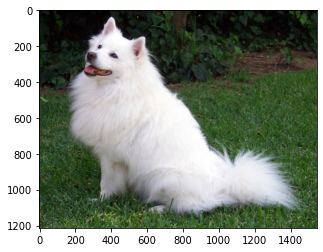

In [29]:
#transformo los datos
input_image = Image.open(filename)
plt.imshow(np.asarray(input_image))

input_tensor = transformers(input_image)
input_batch = input_tensor.unsqueeze(0)

# # move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

# with torch.no_grad():
#   output = model(input_batch)

#predicción del modelo

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    inception_v3_net.to('cuda')
    
with torch.no_grad():
  out = inception_v3_net(input_batch).cpu()

In [30]:

from keras.applications.imagenet_utils import decode_predictions
labs = decode_predictions(out.numpy(),top=1)

print('\n')
print('Nombre de la clase predicha: ', labs[0][0][0],'\n')
print('Descripción de la clase: ', labs[0][0][1],'\n')
print('Valor del puntaje de la red: ',labs[0][0][2])

Using TensorFlow backend.




Nombre de la clase predicha:  n02111889 

Descripción de la clase:  Samoyed 

Valor del puntaje de la red:  22.676172


  3. Segmente la imagen de control utilizando la función ```slic``` del módulo ```skimage.segmentation```, para los parámetros ```start_label=0```, ```n_segments=80```. El resultado de la segmentación es un arreglo de dimensión 299&times;299 que asigna una categoría para cada píxel de la imágen procesada. Todos los pixeles en la imágen que comparten etiqueta conforman un súper-píxel dentro de la imágen. Utilice la función ```mark_boundaries``` del módulo ```skimage.segmentation``` en conjunto con ```imshow``` del módulo ```skimage.io``` para visualizar los bordes inducidos por el conjunto de super-pixeles. 


Imágen segmentada:



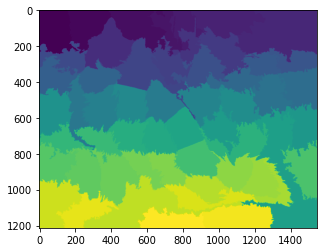

In [31]:
import skimage.segmentation as sks
from skimage.io import imshow as ims

imagen_np = np.asarray(input_image)
imagen_seg = sks.slic(imagen_np, n_segments=80)

print('Imágen segmentada:\n')
#ims(imagen_seg)
plt.imshow(imagen_seg)

Imagen original:



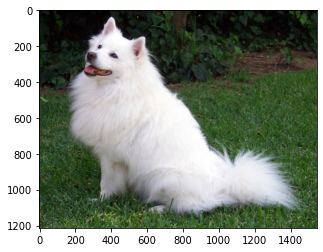

In [32]:
print('Imagen original:\n')
plt.imshow(imagen_np)

Imágen con los super-pixeles marcados en sus bordes:



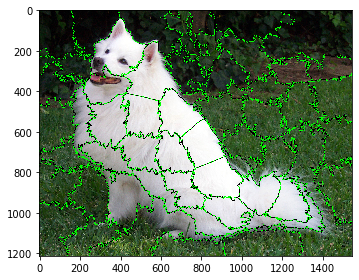

In [33]:
imagen_bnd = sks.mark_boundaries(imagen_np,imagen_seg, color = (0,0,0), outline_color=(0,1,0))
print('Imágen con los super-pixeles marcados en sus bordes:\n')
ims(imagen_bnd)

Al representar una imágen _x_ por medio de la presencia y ausencia de súper-pixeles se logra una representación interpretable _x'_ según un vector de entradas binarias.

Genere perturbaciones en la imágen de control, para esto siga los siguientes pasos:

  4. Defina un número de _perturbaciones_ a realizar (al menos 1000). Cada perturbación consiste en un arreglo binario, donde cada componente es asociada a un súper-pixel. Estos arreglos serán las representaciones interpretables de la imagen de control (_x'_ asociado a _x_). Considere cada entrada del arreglo de perturbaciones como una variable **Bernoulli** con _p=0.5_.

In [34]:
#probaremos con 1000 perturbaciones
n_per = 1000
ind = np.array([(i in imagen_seg) for i in range(80)])
n_clases = len(ind[ind == True])

M = np.zeros([n_clases,n_per])

#binomial(1,p)=bernoulli(p), asigno en una matriz de n_clases x n_perturbaciones donde cada fila corresponde al valor de la clase en esa perturbación.
np.random.seed(10)
for i in range(n_per):
  M[:,i] = np.random.binomial(1,0.5,n_clases)

  5. Genere tantas versiones perturbadas de la imagen de control como perturbaciones haya conseguido. Obtener una imagen perturbada consiste en asignar el valor 0 en cada canal de color en aquellos píxeles cuyos super-pixeles asociados tengan su componente nula en el vector de perturbaciones. Obtenga una visualización de una imágen perturbada.

In [35]:
#generando imágenes perturbadas.

n_x, n_y, n_colores= np.shape(imagen_np) #coordenadas de la imagen normal.

imag_perturb = [] #guardar imágenes perturbadas. guardar en formato Image


for p in range(n_per):
  #para cada perturbación hago una copia de la imagen
  image_copy = imagen_np.copy()
  for i in range(n_x):
    for j in range(n_y):
      pos = imagen_seg[i,j]
      if M[pos,p] == 0:
        image_copy[i,j,:] = [0,0,0]
  
  imag_perturb.append(image_copy)

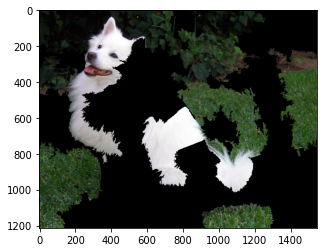

In [36]:
# Mostrar una imágen cualquiera
plt.imshow(imag_perturb[425])

imágenes perturbadas  que sean clasificadas a la misma categoría de la imágen de control y 0 en caso contrario, el arreglo binario correspondiente se denotará _y_.

In [37]:
#función que evalúa una imágen y la compara con una etiqueta según la predicción
def Evaluación_red(imag_array, nombre_cat, print_ = False):
  input_image = Image.fromarray(imag_array)
  input_tensor = transformers(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    inception_v3_net.to('cuda')
    
  with torch.no_grad():
    out = inception_v3_net(input_batch).cpu()
  
  labs = decode_predictions(out.numpy(),top=1)
  
  if print_:
    print(labs[0][0][0])
  
  if labs[0][0][0] == nombre_cat:
    return 1
  else:
    return 0

In [38]:
# nombre de la categoría correcta.
label = labs[0][0][0]
label

'n02111889'

In [39]:
#Prueba de la función
Evaluación_red(imag_perturb[20], label, print_ = True) #no acertó

n01582220


0

In [40]:
#Generación del vector Y
y =[]
for i in range(n_per):
  y.append(Evaluación_red(imag_perturb[i],label))

  7. Calcule &pi;<sub>_x_</sub> según la expresión (3). Para ello, obtenga la distancia del coseno entre las perturbaciones asociadas a cada imágen perturbada y el vector de perturbación de la imágen de control _x_ según lo indica (4).



  Tomamos
$$
x' = (1,\cdots,1)
$$
como el vector que identifica a la imagen original $x$. Entonces, si $N$ es la cantidad de clases encontradas en la segmentación, entonces:

$$
x' \in \{0,1\}^N,\hspace{0.4cm}\text{y }\hspace{0.4cm}||x'|| = \sqrt{N}
$$

In [41]:
# Definimos la distancia.
def dist_x(z):
  n = len(z)
  a = np.sum(z)
  norm_x = np.sqrt(n)
  norm_z = np.sqrt(np.sum(z**2))

  d = 1 - (a/(norm_x*norm_z))
  if norm_z == 0:
    return 1
  else:
    return d

# Definimos la distancia coseno:

def pi_x(z,sigma):
  d = dist_x(z)

  return np.exp((-d**2) / (sigma**2))

In [42]:
# Primera perturbación:
per_0 = M[:,0]
np.shape(per_0)

(54,)

In [43]:
# Prueba de las funciones anteriores para sigma=1.
pi_x(per_0, sigma=1)

0.9311072408543959

Una vez obtenido el conjunto de reprsentaciones para la imágen de control $x$ y el vector de pesos asociados &pi;<sub>$x$</sub>, se pasa a minimizar la función de fidelidad, para esto:

  8. Genere un conjunto de entrenamiento $D_p$. Este consta de vectores de perturbación como observaciones. La variable de respuesta será el arreglo $y$ generado anteriormente.

In [44]:
D_p = [M[:,i] for i in range(n_per)]

# y definido anteriormente.

  9. Utilice la clase ```LogisticRegression``` del módulo ```sklearn.linear_model``` para entrenar un clasificador sobre el conjunto de entrenamiento $D_p$. Haga uso de $\pi_x$ al momento de usar el método ```.fit()```. ¿Es posible agregar una medida de complejidad $\Omega(g)$ con este esquema?

In [45]:
from sklearn.linear_model import LogisticRegression
sigma = 0.25
weight = np.array([pi_x(D_p[i],sigma) for i in range(n_per)])

reg = LogisticRegression().fit(D_p,y, sample_weight=weight)

In [46]:
reg.coef_

array([[-2.64827420e-02, -6.63580889e-02,  2.56404950e-01,
         3.71195803e-02, -3.97654532e-02, -3.03327394e-01,
        -2.68310049e-01,  3.42085525e+00,  9.74660848e-02,
        -1.09905380e-01,  9.18376849e-02,  4.17649876e+00,
        -1.91141847e-01,  3.71064555e-01, -8.62700089e-02,
        -1.38582217e-01,  2.57044555e-03,  4.71345847e-01,
         1.11811104e-01, -8.16686634e-02,  1.12374668e-02,
         2.76525468e-01,  8.77744621e-01,  6.40261879e-01,
        -3.88966851e-01, -1.46022519e-01,  8.66032268e-02,
         1.41731901e-01, -6.36762290e-02,  1.68025733e-01,
         8.54160861e-03,  1.46708945e-01,  3.95388372e-01,
         7.66121788e-02,  1.74171420e-01, -1.72535207e-01,
         7.02755983e-02, -3.78850436e-02, -2.27455874e-01,
        -1.11875957e-01, -1.65024243e-01, -3.66884345e-01,
        -2.37559449e-01, -3.52636795e-01, -8.64595639e-02,
         8.98899514e-02, -6.46786305e-03, -1.79836551e-01,
         1.74153092e-01, -4.88423871e-02, -1.93709823e-0

   10. Utilice los coeficientes del clasificador anterior para inferir los súper-índices de mayor importancia en la clasificación de la imágen de control.

Dado que la regresión logística vincula a la variable $X$ con la respuesta $Y$ de una forma no lineal, no se analizarán a los coeficientes por el tamaño de su magnitud (módulo) como en la regresión lineal. En cambio, la importancia de la variable estará dada por un factor exponencial del coeficiente. Es decir, si $\beta_i$ es el coeficiente asociado al súper-píxel $i$, entonces la importancia de tal súperpixel se puede medir mediante:

$$
e^{\beta_i}
$$

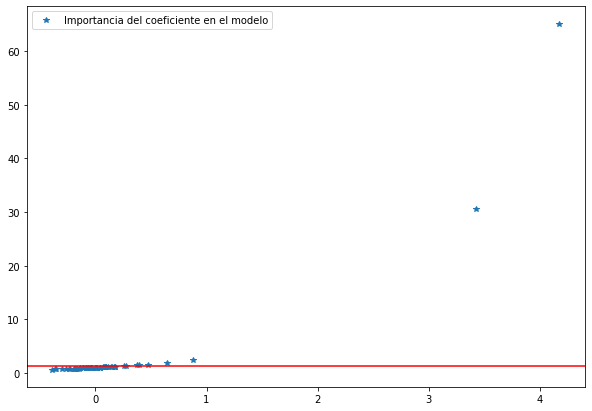

In [47]:
coef = np.array(reg.coef_[0])

#región de corte al valor de ln(1.4)
plt.figure(figsize = (10,7))
plt.plot(coef, np.exp(coef), '*', label = 'Importancia del coeficiente en el modelo')
plt.axhline(y=1.4, xmin=0, xmax=1, color = 'r')
plt.legend()

In [48]:
sup_pix = coef[coef > np.log(1.4)]
Importantes = [i for i in range(54) if coef[i] in sup_pix]
print(Importantes)

[7, 11, 13, 17, 22, 23, 32]


In [49]:
# Generamos una imágen que contenga a los superpixéles más importantes:
M_reg = np.zeros(54)
for i in range(54):
  if i in Importantes:
    M_reg[i] = 1


image_new = imagen_np.copy()
for i in range(n_x):
  for j in range(n_y):
    pos = imagen_seg[i,j]
    if M_reg[pos] == 0:
      image_new[i,j,:] = [0,0,0]

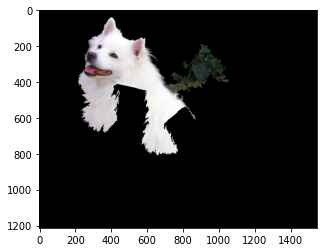

In [50]:
plt.imshow(image_new)

A medida que aumentamos el criterio de elección de los super-pixeles (mayores coeficientes) notamos que los pixeles que se mantienen siempre entre aquellos que el modelo necesita ver para tomar una buena desición son aquellos que están cercanos a la cara del perro (en este caso). Esto es explicado por el nivel de detalle (y por lo tanto, de información) que contiene la imágen y que la diferencia de otras que puedan poseer colores u otras características similares.

La segmentación antes utilizada se hace de _manera espacial_. Es decir, se realiza una clusterización sobre la escala de grises según su posición en la imágen. Del procediminto recién explicado para implementar **LIME** reemplace la etapa de segmentación de la imágen por 2 segmentaciones espaciales utilizando 2 modelos de clustering a su elección, para ello:

  11. Clusterice sobre un conjunto de entrenamiento $X$ con $299^2$ observaciones, es decir, una observación por píxel en la imagen del control escalada. Cada Observación de $X$ consta de 3 componentes, donde la primera y segunda son espaciales (posición del píxel en la imágen) y la última es el valor de intensidad asociado al píxel (escala de grises). Utilice los cluster descubiertos para generar súper-píxeles.

In [51]:
# Algoritmo clusterizador a ocupar: K-means
# Luego de cargar la imágen en 2d (escala de grises), se genera una matriz de datos donde la fila corresponde al vecrtor [posición_x, posición_y, color_de_(x,y)]

from sklearn.cluster import KMeans
newsize = (299,299)
image_ = np.asarray(Image.open(filename).resize(newsize).convert('RGB'))
image_2d = np.mean(image_, axis=2, dtype=np.uint)
np.shape(image_2d)

(299, 299)

In [52]:
X_km = []

for i in range(299):
  for j in range(299):
    X_km.append([i,j, image_2d[i,j]])

In [53]:
kmean = KMeans().fit_predict(X_km)
np.shape(kmean) # vector de etiquetas para cada vector de X_km, necesario reordenar en matrix de 299x299 para graficar vecindades

(89401,)

In [54]:
kmean_pix = kmean.reshape([299,299])
kmean_pix.max() +1 #cantidad de clases

8

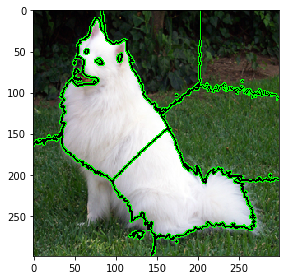

In [55]:
imagen_bnd2 = sks.mark_boundaries(image_,kmean_pix, color = (0,0,0), outline_color=(0,1,0))
ims(imagen_bnd2)

Podemos observar que la mayor cantidad de clusters se concentran en la cara del perro, lugar que, según el modelo anterior, era imprescindible para que la red pueda reconocer la imágen. Clusterización reconoce el pasto, el fondo y el cuerpo del perro como secciones distintas (esto es un poco evidente, puesto que los colores que predominaban en la imágen eran notoriamente distintos, por lo tanto el valor en la imágen también).
Veamos la importancia de cada cluster visto como segmentaciones de los pasos anteriores.


  12. Aplique el esquema **LIME** desarrollado anteriormente sobre sus súper-pixeles.
  

In [56]:
#probaremos con 1000 perturbaciones denuevo

n_clases_km = kmean_pix.max() +1

M2 = np.zeros([n_clases_km,n_per])

#binomial(1,p)=bernoulli(p), asigno en una matriz de n_clases x n_perturbaciones donde cada fila corresponde al valor de la clase en esa perturbación.
np.random.seed(10)
for i in range(n_per):
  M2[:,i] = np.random.binomial(1,0.5,n_clases_km)

In [57]:
#generando imágenes perturbadas.

imag_perturb_km = [] #guardar imágenes perturbadas. guardar en formato Image


for p in range(n_per):
  #para cada perturbación hago una copia de la imagen
  image_copy = image_.copy()
  for i in range(299):
    for j in range(299):
      pos = kmean_pix[i,j]
      if M2[pos,p] == 0:
        image_copy[i,j,:] = [0,0,0]
  
  imag_perturb_km.append(image_copy)

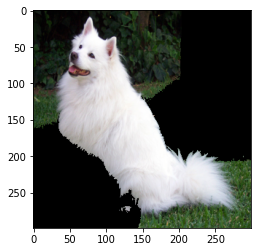

In [58]:
# Mostrar una imágen cualquiera 
plt.imshow(imag_perturb_km[640])

In [59]:
#Generación del vector Y
y_km =[]
for i in range(n_per):
  y_km.append(Evaluación_red(imag_perturb_km[i],label))

In [60]:
D_km = [M2[:,i] for i in range(n_per)]
weight_km = np.array([pi_x(D_km[i],sigma) for i in range(n_per)])

reg_km = LogisticRegression().fit(D_km,y_km, sample_weight=weight_km)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


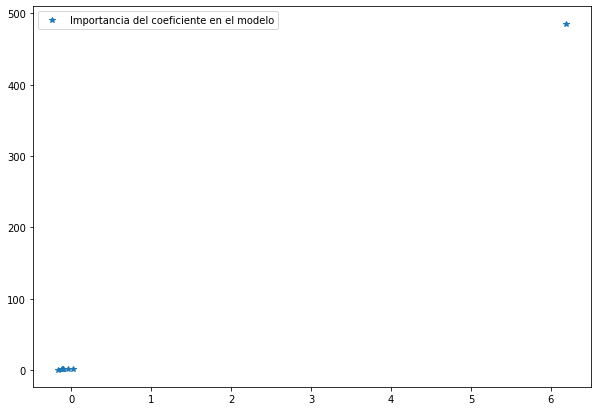

In [61]:
coef_km = np.array(reg_km.coef_[0])

#región de corte al valor de ln(1.4)
plt.figure(figsize = (10,7))
plt.plot(coef_km, np.exp(coef_km), '*', label = 'Importancia del coeficiente en el modelo')
# plt.axhline(y=1.4, xmin=0, xmax=1, color = 'r')
plt.legend()

Podemos ver sólo un coeficiente positivo (mayor a 6), por lo tanto al aplicar la exponencial, separa brúscamente este coeficiente de los demáses que los sitúa por debajo de 1.

[2] 



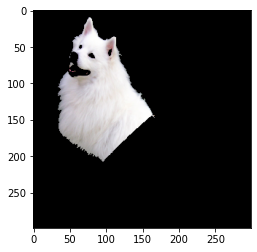

In [62]:
sup_pix_km = coef_km[coef_km > np.log(100)]
Importantes_km = [i for i in range(8) if coef_km[i]> np.log(100)]
print(Importantes_km,'\n')

# Generamos una imágen que contenga a los superpixéles más importantes:

coef_image = image_.copy()
for i in range(299):
  for j in range(299):
    if kmean_pix[i,j] not in Importantes_km:
      coef_image[i,j,:] = [0,0,0]

plt.imshow(coef_image)

Al igual que la parte anterior, el aspecto más importante de la imágen es la forma que presenta la cara del perro, sin embargo (y no es muy notorio) no considera detalles de la cada, como los ojos, la nariz y el ocico. Esto puede ser por el color negro que presentan, lo que hace que anular el cluster en esa zona no presente mayor diferencia en el modelo, pues el color no cambia drásticamente como el resto del cuerpo. Bajo esa lógica es claro que el modelo de regesión no dará peso de importancia a aquellos cluster.
